In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Text Pre-processing libraries
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Tensorflow imports to build the model.
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Hate_Speech.csv')
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
df.shape

(24783, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


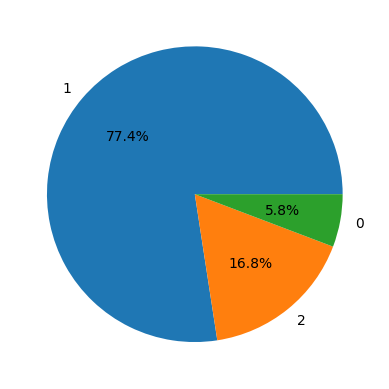

In [5]:
plt.pie(df['class'].value_counts().values,
		labels = df['class'].value_counts().index,
		autopct='%.1f%%')
plt.show()

In [6]:
# Lower case all the words
df['tweet'] = df['tweet'].str.lower()

# Removing punctuations
punctuations_list = string.punctuation
def remove_punctuations(text):
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

df['tweet']= df['tweet'].apply(lambda x: remove_punctuations(x))
df.head()

,class,tweet
0,2,rt mayasolovely as a woman you shouldnt compl...
1,1,rt mleew17 boy dats coldtyga dwn bad for cuff...
2,1,rt urkindofbrand dawg rt 80sbaby4life you eve...
3,1,rt cganderson vivabased she look like a tranny
4,1,rt shenikaroberts the shit you hear about me ...


In [7]:
def remove_stopwords_and_lemmatize(text):
	stop_words = stopwords.words('english')
	lemmatizer = WordNetLemmatizer()

	words = []

	for word in str(text).split():

		if word not in stop_words:

			# Lemmatizing the word
			lemmatized_word = lemmatizer.lemmatize(word)

			words.append(lemmatized_word)

	output = " ".join(words)

	return output

df['tweet'] = df['tweet'].apply(lambda text: remove_stopwords_and_lemmatize(text))
df.head()

,class,tweet
0,2,rt mayasolovely woman shouldnt complain cleani...
1,1,rt mleew17 boy dat coldtyga dwn bad cuffin dat...
2,1,rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3,1,rt cganderson vivabased look like tranny
4,1,rt shenikaroberts shit hear might true might f...


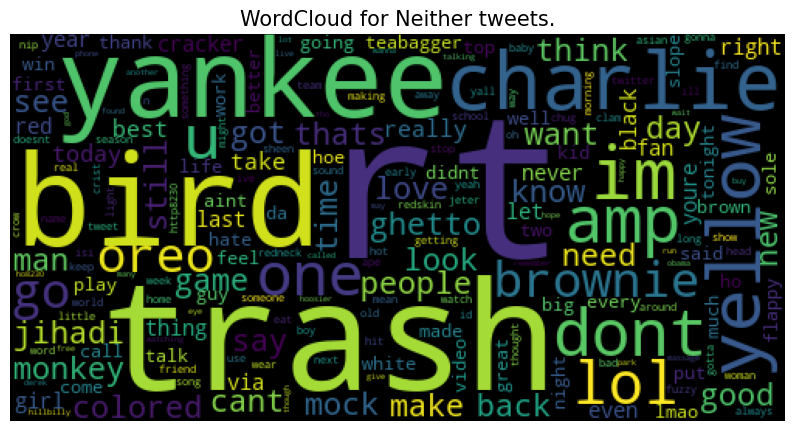

In [8]:
def plot_word_cloud(data, typ):

  corpus = " ".join(data['tweet'])

  plt.figure(figsize = (10,10))


  wc = WordCloud(width = 500,
                height = 250,
                collocations = False).generate(corpus)

  # Plotting the wordcloud
  plt.title(f'WordCloud for {typ} tweets.', fontsize = 15)
  plt.axis('off')
  plt.imshow(wc)
  plt.show()
plot_word_cloud(df[df['class']==2], typ='Neither')

In [9]:
class_2 = df[df['class'] == 2]
class_1 = df[df['class'] == 1].sample(n=4300)
class_0 = df[df['class'] == 0]

balanced_df = pd.concat([class_0, class_0, class_0, class_1, class_2], axis=0)

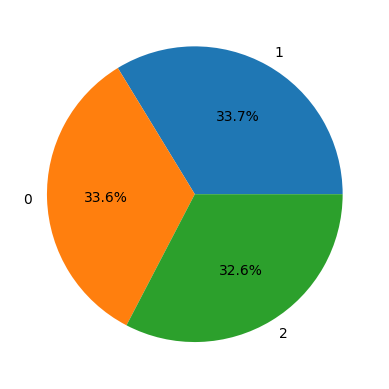

In [10]:
plt.pie(balanced_df['class'].value_counts().values,
		labels=balanced_df['class'].value_counts().index,
		autopct='%.1f%%')
plt.show()

In [11]:
features = balanced_df['tweet']
target = balanced_df['class']

X_train, X_test, Y_train, Y_test = train_test_split(features,
												target,
												test_size=0.2,
												random_state=1)
X_train.shape, X_test.shape

((10202,), (2551,))

In [12]:
Y_train = pd.get_dummies(Y_train)
Y_test = pd.get_dummies(Y_test)
Y_train.shape, Y_test.shape

((10202, 3), (2551, 3))

In [13]:
# max_words = 5000
# max_len = 100

# token = Tokenizer(num_words=max_words,
# 				lower=True,
# 				split=' ')

# token.fit_on_texts(X_train)

### It uses an embedding layer to convert words into vectors, a bidirectional LSTM to process sequences of text, followed by a dense layer for classification with L2 regularization, batch normalization, and dropout to improve generalization. Finally, the softmax output layer predicts the probability distribution over 3 possible classes.

In [23]:
max_words = 5000
max_len = 100

model = keras.models.Sequential([
	layers.Embedding(max_words, 32, input_length=max_len),
	layers.Bidirectional(layers.LSTM(16)),
	layers.Dense(256, activation='relu', kernel_regularizer='l2'),
	layers.BatchNormalization(),
	layers.Dropout(0.2),
	layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
			optimizer='adam',
			metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.build((None, max_len))

In [25]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.25,
					verbose = 0)

In [26]:
from tensorflow.keras.utils import pad_sequences

# Tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences for uniform length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len)

# fit the model
history = model.fit(X_train_padded, Y_train,
					validation_data=(X_test_padded, Y_test),
					epochs=50,
					verbose=1,
					batch_size=32,
					callbacks=[lr, es])

Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.7033 - loss: 0.9683 - val_accuracy: 0.5390 - val_loss: 0.9159 - learning_rate: 0.0010
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.9042 - loss: 0.2868 - val_accuracy: 0.8122 - val_loss: 0.4773 - learning_rate: 0.0010
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - accuracy: 0.9403 - loss: 0.1848 - val_accuracy: 0.8824 - val_loss: 0.4189 - learning_rate: 0.0010
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - accuracy: 0.9582 - loss: 0.1365 - val_accuracy: 0.8714 - val_loss: 0.4854 - learning_rate: 0.0010
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.9674 - loss: 0.1154 - val_accuracy: 0.8742 - val_loss: 0.4586 - learning_rate: 0.0010
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.9771 - loss: 0.0865 - val_accuracy: 0.8926 - val_loss: 0.4587 - learning_rate: 2.5000e-04
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - accuracy: 0.9852

### the first implemamtation

In [20]:

# from tensorflow.keras.utils import pad_sequences

# # Tokenizer
# tokenizer = Tokenizer(num_words=max_words)
# tokenizer.fit_on_texts(X_train)

# # Convert text to sequences
# X_train_seq = tokenizer.texts_to_sequences(X_train)
# X_test_seq = tokenizer.texts_to_sequences(X_test)

# # Pad sequences for uniform length
# X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)
# X_test_padded = pad_sequences(X_test_seq, maxlen=max_len)

# # fit the model
# history = model.fit(X_train_padded, Y_train,
# 					validation_data=(X_test_padded, Y_test),
# 					epochs=50,
# 					verbose=1,
# 					batch_size=32,
# 					callbacks=[lr, es])

Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.6926 - loss: 3.6547 - val_accuracy: 0.5696 - val_loss: 0.9967 - learning_rate: 0.0010
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.9030 - loss: 0.3671 - val_accuracy: 0.7907 - val_loss: 0.5595 - learning_rate: 0.0010
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9342 - loss: 0.2731 - val_accuracy: 0.8655 - val_loss: 0.5327 - learning_rate: 0.0010
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.9512 - loss: 0.2111 - val_accuracy: 0.8828 - val_loss: 0.4638 - learning_rate: 0.0010
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.9660 - loss: 0.1685 - val_accuracy: 0.8808 - val_loss: 0.4502 - learning_rate: 0.0010
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.9692 - loss: 0.1504 - val_accuracy: 0.8397 - val_loss: 0.6779 - learning_rate: 0.0010
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.9699 - l

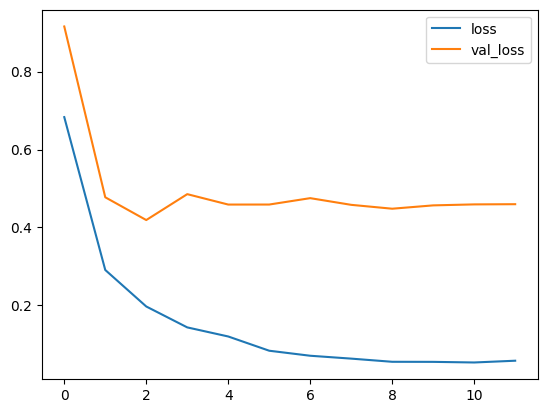

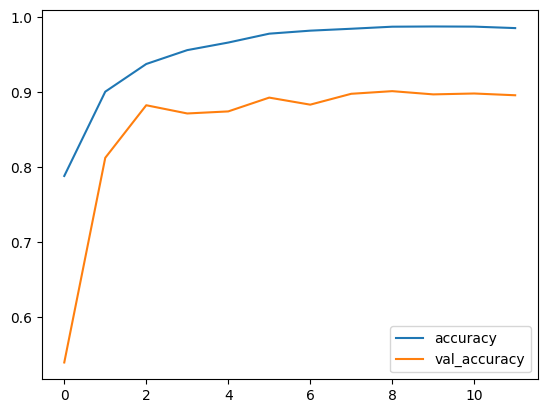

In [27]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()